In [1]:
#Importing Libraries

import pandas as pd
import numpy as np
import re 
import nltk 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import warnings
import keras
from keras.layers import Dense,LSTM,Embedding,Input,GlobalMaxPool1D
from keras.models import Sequential
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


from io import StringIO
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
import matplotlib.patches as mpatches

In [2]:
#Importing Dataset

train = pd.read_csv("Corona_NLP_train.csv", encoding='latin1')
test = pd.read_csv("Corona_NLP_test.csv", encoding='latin1')
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


### Only Location has some null values but that column is not important so we won't drop the whole row because of Location null

In [4]:
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [5]:
test.isnull().any()

UserName         False
ScreenName       False
Location          True
TweetAt          False
OriginalTweet    False
Sentiment        False
dtype: bool

In [6]:
train.shape

(41157, 6)

In [7]:
test.shape

(3798, 6)

## EDA

C:\Users\EraiYamuthan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

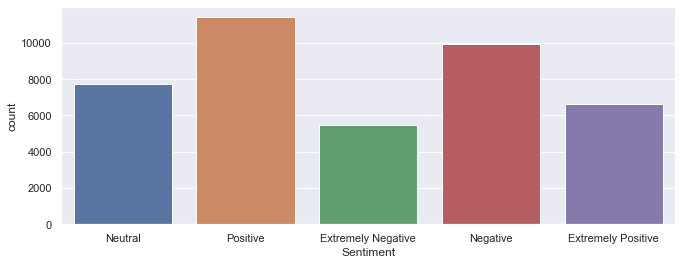

In [8]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11,4)})
sns.countplot(train['Sentiment'])

### Changing the sentiment to 3 classes only

In [9]:
def change_sen(sentiment):
    if sentiment == "Extremely Positive":
        return 'positive'
    elif sentiment == "Extremely Negative":
        return 'negative'
    elif sentiment == "Positive":
        return 'positive'
    elif sentiment == "Negative":
        return 'negative'
    else:
        return 'netural'

In [10]:
train['Sentiment']=train['Sentiment'].apply(lambda x:change_sen(x))
test['Sentiment']=test['Sentiment'].apply(lambda x:change_sen(x))

In [11]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,netural
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",negative


In [12]:
from nltk.corpus import stopwords
# load stop words
stop_word = stopwords.words('english')

In [13]:
#Cleaning the tweet

def clean(text):
    #     remove urls
    text = re.sub(r'http\S+', " ", text)
    #     remove mentions
    text = re.sub(r'@\w+',' ',text)
    #     remove hastags
    text = re.sub(r'#\w+', ' ', text)
    #     remove digits
    text = re.sub(r'\d+', ' ', text)
    #     remove html tags
    text = re.sub('r<.*?>',' ', text) 
    #     remove stop words 
    text = text.split()
    text = " ".join([word for word in text if not word in stop_word])
        
    return text

In [14]:
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: clean(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x: clean(x))

### We only need Original Tweet and Sentiment column

In [15]:
train = train.iloc[:,4:]
test = test.iloc[:,4:]

In [16]:
train.head()

,OriginalTweet,Sentiment
0,,netural
1,advice Talk neighbours family exchange phone n...,positive
2,Coronavirus Australia: Woolworths give elderly...,positive
3,"My food stock one empty... PLEASE, panic, THER...",positive
4,"Me, ready go supermarket outbreak. Not I'm par...",negative


In [17]:
test.head()

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,negative
1,"When I find hand sanitizer Fred Meyer, I turne...",positive
2,Find protect loved ones . ?,positive
3,buying hits City anxious shoppers stock food&a...,negative
4,One week everyone buying baby milk powder next...,netural


In [18]:
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'Sentiment'.
train['Sentiment']= label_encoder.fit_transform(train['Sentiment'])
  
train['Sentiment'].unique()

array([1, 2, 0])

In [19]:
train.head()

,OriginalTweet,Sentiment
0,,1
1,advice Talk neighbours family exchange phone n...,2
2,Coronavirus Australia: Woolworths give elderly...,2
3,"My food stock one empty... PLEASE, panic, THER...",2
4,"Me, ready go supermarket outbreak. Not I'm par...",0


## Negative 0
## Neutral 1
## Positive 2

In [20]:
train_text,val_text,train_label,val_label=train_test_split(train.OriginalTweet,train.Sentiment,
                                                             test_size=0.3,random_state=42)

## Lemmatization
#### In lemmatization, we try to reduce a given word to its root word.

In [21]:
class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, sentence):
        sentence=re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)',' ',sentence)
        sentence=re.sub('[^0-9a-z]',' ',sentence)
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>1]

In [22]:
tokenizer=CountVectorizer(max_features=5000,stop_words='english',lowercase=True,tokenizer=Lemmatizer())

In [23]:
train_x=tokenizer.fit_transform(train_text).toarray()

C:\Users\EraiYamuthan\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [24]:
tokenizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': 'english',
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': <__main__.Lemmatizer at 0x1bc2fc7d610>,
 'vocabulary': None}

In [25]:
feature_names=tokenizer.get_feature_names()

In [26]:
val_x=tokenizer.transform(val_text).toarray()

In [27]:
test_x=test.OriginalTweet
test_label=label_encoder.transform(test['Sentiment'])

In [28]:
test_x_1=tokenizer.transform(test_x).toarray()

## LSTM

In [29]:
early_stop=EarlyStopping(monitor='val_accuracy',patience=3)
reduceLR=ReduceLROnPlateau(monitor='val_accuarcy',patience=2)

In [30]:
token=Tokenizer(num_words=5000,oov_token=Lemmatizer())
token.fit_on_texts(train_text)
train_x_2=token.texts_to_sequences(train_text)
train_x_2=pad_sequences(train_x_2,maxlen=60,padding='post',truncating='post')

In [31]:
val_x_2=token.texts_to_sequences(val_text)
val_x_2=pad_sequences(val_x_2,maxlen=60,padding='post',truncating='post')

In [32]:
embedding_dimension=32
v=len(token.word_index)
model=Sequential()
model.add(Input(shape=(60,)))
model.add(Embedding(v+1,embedding_dimension))
model.add(LSTM(64,return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dense(64))
model.add(Dense(3,activation='softmax'))

In [33]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
r=model.fit(train_x_2,train_label,validation_data=(val_x_2,val_label),
            epochs=50,batch_size=64,callbacks=[reduceLR,early_stop])

Epoch 1/50
451/451 [==============================] - 26s 52ms/step - loss: 0.8589 - accuracy: 0.5827 - val_loss: 0.4911 - val_accuracy: 0.8324
Epoch 2/50
451/451 [==============================] - 25s 55ms/step - loss: 0.4023 - accuracy: 0.8703 - val_loss: 0.4523 - val_accuracy: 0.8477
Epoch 3/50
451/451 [==============================] - 23s 50ms/step - loss: 0.3455 - accuracy: 0.8882 - val_loss: 0.4459 - val_accuracy: 0.8524
Epoch 4/50
451/451 [==============================] - 24s 53ms/step - loss: 0.3051 - accuracy: 0.9034 - val_loss: 0.4708 - val_accuracy: 0.8437
Epoch 5/50
451/451 [==============================] - 25s 55ms/step - loss: 0.2593 - accuracy: 0.9146 - val_loss: 0.4779 - val_accuracy: 0.8410
Epoch 6/50
451/451 [==============================] - 25s 55ms/step - loss: 0.2215 - accuracy: 0.9282 - val_loss: 0.5294 - val_accuracy: 0.8332


[]

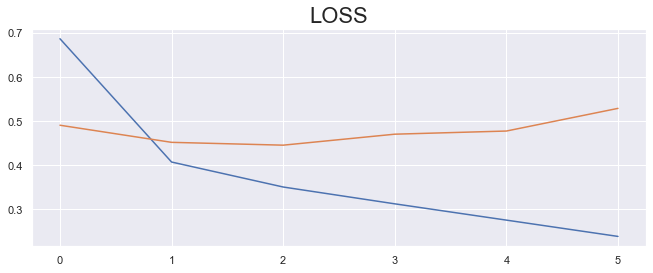

In [34]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('LOSS',fontdict={'size':'22'})
plt.plot()

In [35]:
test_x_2=token.texts_to_sequences(test['OriginalTweet'])
test_x_2=pad_sequences(test_x_2,maxlen=60,padding='post',truncating='post')

### Accuracy on Test set

In [36]:
print(classification_report(test_label,model.predict_classes(test_x_2)))

C:\Users\EraiYamuthan\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.83      0.78      0.81      1633
           1       0.79      0.70      0.74       619
           2       0.79      0.88      0.83      1546

    accuracy                           0.81      3798
   macro avg       0.80      0.79      0.79      3798
weighted avg       0.81      0.81      0.81      3798



## Bidirectional LSTM

In [37]:
from keras.layers import Bidirectional

embedding_dimension=32
v=len(token.word_index)
modelnew=Sequential()
modelnew.add(Input(shape=(60,)))
modelnew.add(Embedding(v+1,embedding_dimension))
modelnew.add(Bidirectional(LSTM(64,return_sequences=True)))
modelnew.add(GlobalMaxPool1D())
modelnew.add(Dense(64))
modelnew.add(Dense(3,activation='softmax'))

In [38]:
modelnew.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
r=modelnew.fit(train_x_2,train_label,validation_data=(val_x_2,val_label),
            epochs=50,batch_size=64,callbacks=[reduceLR,early_stop])

Epoch 1/50
451/451 [==============================] - 38s 74ms/step - loss: 0.8537 - accuracy: 0.5848 - val_loss: 0.4752 - val_accuracy: 0.8418
Epoch 2/50
451/451 [==============================] - 30s 68ms/step - loss: 0.3912 - accuracy: 0.8763 - val_loss: 0.4313 - val_accuracy: 0.8535
Epoch 3/50
451/451 [==============================] - 32s 71ms/step - loss: 0.3226 - accuracy: 0.8968 - val_loss: 0.4373 - val_accuracy: 0.8554
Epoch 4/50
451/451 [==============================] - 36s 80ms/step - loss: 0.2835 - accuracy: 0.9068 - val_loss: 0.4553 - val_accuracy: 0.8490
Epoch 5/50
451/451 [==============================] - 33s 72ms/step - loss: 0.2234 - accuracy: 0.9228 - val_loss: 0.4938 - val_accuracy: 0.8412
Epoch 6/50
451/451 [==============================] - 44s 97ms/step - loss: 0.1780 - accuracy: 0.9433 - val_loss: 0.5695 - val_accuracy: 0.8273
